# Load data (functions):

In [0]:
from pathlib import Path
import requests
import zipfile
import glob

In [0]:
output_folder_path = '.'
output_folder_path = Path(output_folder_path)
img_width = 200
img_height = 150

In [0]:
def download_url(url, save_path=False, chunk_size=128):
    "downloads zip files to the folder that the notebook / python file is saved"

    if not save_path:
        save_path = url.split('/')[-1]

    with requests.get(url, stream=True) as r:
        with open(save_path, 'wb') as fd:
            for chunk in r.iter_content(chunk_size=chunk_size):
                fd.write(chunk)
    print(f"file {save_path} succesfuly downloaded")

In [0]:
def unzip_to_structure(zipfile_path, output_root_folder):
    """unzips files to specified output root folder with structure: 
        <output_root_folder> / <set_type> / <city> / <img_key>.jpg"""

    output_root_folder = Path(output_root_folder)
    file_parts = str(Path(zipfile_path).stem).split('_')
    city = file_parts[0]
    set_type = file_parts[1]
    for s in ['train','test','val']:   
      with zipfile.ZipFile(zipfile_path, 'r') as zip_ref:
        if set_type == s:
          zip_ref.extractall(output_root_folder / s )
    print(f"images from '{zipfile_path}' succesfuly unziped to '{output_root_folder / s / city}'")

In [0]:
def get_images(cities,output_path=output_folder_path):
  """gets all images for defined cities
  param:: cities, array of cities
  param:: output_path """
  linkz = []

  for city in cities:
    for link in links:
      if city in link:
        linkz.append(link) 
  # download files to current directory

  for link in linkz:
      download_url(link)
  
  # unzip images to destination with format: 
  # <output_root_folder> / <set_type> / <city> / <img_key>.jpg
  for link in linkz:
      filename = Path(link).name
      unzip_to_structure(filename,output_path)   

In [0]:
train_links = ['https://ww-research.s3-us-west-2.amazonaws.com/Arad/adidas/paris_train.zip',
  'https://ww-research.s3-us-west-2.amazonaws.com/Arad/adidas/austin_train.zip',
  'https://ww-research.s3-us-west-2.amazonaws.com/Arad/adidas/melbourne_train.zip',
  'https://ww-research.s3-us-west-2.amazonaws.com/Arad/adidas/moscow_train.zip',
  'https://ww-research.s3-us-west-2.amazonaws.com/Arad/adidas/cph_train.zip',
  'https://ww-research.s3-us-west-2.amazonaws.com/Arad/adidas/helsinki_train.zip',
  'https://ww-research.s3-us-west-2.amazonaws.com/Arad/adidas/manila_train.zip',
  'https://ww-research.s3-us-west-2.amazonaws.com/Arad/adidas/tokyo_train.zip',
  'https://ww-research.s3-us-west-2.amazonaws.com/Arad/adidas/phoenix_train.zip',
  'https://ww-research.s3-us-west-2.amazonaws.com/Arad/adidas/goa_train.zip',
  'https://ww-research.s3-us-west-2.amazonaws.com/Arad/adidas/sf_train.zip',
  'https://ww-research.s3-us-west-2.amazonaws.com/Arad/adidas/boston_train.zip',
  'https://ww-research.s3-us-west-2.amazonaws.com/Arad/adidas/budapest_train.zip',
  'https://ww-research.s3-us-west-2.amazonaws.com/Arad/adidas/toronto_train.zip',
  'https://ww-research.s3-us-west-2.amazonaws.com/Arad/adidas/berlin_train.zip',
  'https://ww-research.s3-us-west-2.amazonaws.com/Arad/adidas/amsterdam_train.zip',
  'https://ww-research.s3-us-west-2.amazonaws.com/Arad/adidas/saopaulo_train.zip',
  'https://ww-research.s3-us-west-2.amazonaws.com/Arad/adidas/ottawa_train.zip',
  'https://ww-research.s3-us-west-2.amazonaws.com/Arad/adidas/bangkok_train.zip']
val_links = ['https://ww-research.s3-us-west-2.amazonaws.com/Arad/adidas/paris_val.zip',
  'https://ww-research.s3-us-west-2.amazonaws.com/Arad/adidas/austin_val.zip',
  'https://ww-research.s3-us-west-2.amazonaws.com/Arad/adidas/melbourne_val.zip',
  'https://ww-research.s3-us-west-2.amazonaws.com/Arad/adidas/moscow_val.zip',
  'https://ww-research.s3-us-west-2.amazonaws.com/Arad/adidas/cph_val.zip',
  'https://ww-research.s3-us-west-2.amazonaws.com/Arad/adidas/helsinki_val.zip',
  'https://ww-research.s3-us-west-2.amazonaws.com/Arad/adidas/manila_val.zip',
  'https://ww-research.s3-us-west-2.amazonaws.com/Arad/adidas/tokyo_val.zip',
  'https://ww-research.s3-us-west-2.amazonaws.com/Arad/adidas/phoenix_val.zip',
  'https://ww-research.s3-us-west-2.amazonaws.com/Arad/adidas/goa_val.zip',
  'https://ww-research.s3-us-west-2.amazonaws.com/Arad/adidas/sf_val.zip',
  'https://ww-research.s3-us-west-2.amazonaws.com/Arad/adidas/boston_val.zip',
  'https://ww-research.s3-us-west-2.amazonaws.com/Arad/adidas/budapest_val.zip',
  'https://ww-research.s3-us-west-2.amazonaws.com/Arad/adidas/toronto_val.zip',
  'https://ww-research.s3-us-west-2.amazonaws.com/Arad/adidas/berlin_val.zip',
  'https://ww-research.s3-us-west-2.amazonaws.com/Arad/adidas/amsterdam_val.zip',
  'https://ww-research.s3-us-west-2.amazonaws.com/Arad/adidas/saopaulo_val.zip',
  'https://ww-research.s3-us-west-2.amazonaws.com/Arad/adidas/ottawa_val.zip',
  'https://ww-research.s3-us-west-2.amazonaws.com/Arad/adidas/bangkok_val.zip']

links = train_links+val_links

In [7]:
links

['https://ww-research.s3-us-west-2.amazonaws.com/Arad/adidas/paris_train.zip',
 'https://ww-research.s3-us-west-2.amazonaws.com/Arad/adidas/austin_train.zip',
 'https://ww-research.s3-us-west-2.amazonaws.com/Arad/adidas/melbourne_train.zip',
 'https://ww-research.s3-us-west-2.amazonaws.com/Arad/adidas/moscow_train.zip',
 'https://ww-research.s3-us-west-2.amazonaws.com/Arad/adidas/cph_train.zip',
 'https://ww-research.s3-us-west-2.amazonaws.com/Arad/adidas/helsinki_train.zip',
 'https://ww-research.s3-us-west-2.amazonaws.com/Arad/adidas/manila_train.zip',
 'https://ww-research.s3-us-west-2.amazonaws.com/Arad/adidas/tokyo_train.zip',
 'https://ww-research.s3-us-west-2.amazonaws.com/Arad/adidas/phoenix_train.zip',
 'https://ww-research.s3-us-west-2.amazonaws.com/Arad/adidas/goa_train.zip',
 'https://ww-research.s3-us-west-2.amazonaws.com/Arad/adidas/sf_train.zip',
 'https://ww-research.s3-us-west-2.amazonaws.com/Arad/adidas/boston_train.zip',
 'https://ww-research.s3-us-west-2.amazonaws.c

# Convolutional Neural Network (class):

In [8]:
# imports:
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Activation, Flatten, Dense
from keras.optimizers import SGD
from keras import backend as K
from keras.utils import np_utils
import numpy as np
import argparse
import cv2
import matplotlib.pyplot as plt
import pandas as pd 
import os

Using TensorFlow backend.


In [0]:
# load class LeNet:
class LeNet:
    @staticmethod
    def build(numChannels, imgRows, imgCols, numClasses,
        activation="relu", weightsPath=None):
        # initialize the model
        model = Sequential()
        inputShape = (imgRows, imgCols, numChannels)
        # if we are using "channels first", update the input shape
        if K.image_data_format() == "channels_first":
            inputShape = (numChannels, imgRows, imgCols)

        # define the first set of CONV => ACTIVATION => POOL layers
        model.add(Conv2D(100, 3, padding="same",
        input_shape=inputShape))
        model.add(Activation(activation))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))      

        # define the second set of CONV => ACTIVATION => POOL layers
        model.add(Conv2D(50, 5, padding="same"))
        model.add(Activation(activation))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        
        # define the first FC => ACTIVATION layers
        model.add(Flatten())
        model.add(Dense(500))
        model.add(Activation(activation))
        
        # define the second FC layer
        model.add(Dense(numClasses))
        # lastly, define the soft-max classifier
        model.add(Activation("softmax"))
        
        # if a weights path is supplied (inicating that the model was
        # pre-trained), then load the weights
        if weightsPath is not None:
            model.load_weights(weightsPath)
        # return the constructed network architecture
        return model

## Prepare data sets for training (functions):

In [0]:
def create_train_val_test_set(dir_train='train', dir_val='val', dir_test='test'):

    # get file lists
    train_images = load_images_from_dir(dir_train)
    val_images = load_images_from_dir(dir_val)
    # test_images = load_images_from_dir(dir_val) ##commented for now


    X_train, y_train = preprocess_images(train_images)
    X_val, y_val = preprocess_images(val_images)
    # X_test, y_test = preprocess_images(test_images)  ##commented for now

    return X_train, y_train, X_val, y_val

In [0]:
def load_images_from_dir(directory):
  """Load all images from given directory and subdirectory"""

  list_of_images = []

  # get content of directory:
  for d in os.listdir(directory):
      if os.path.isdir(directory+ '/' + d):

          # get files from subdirectories:
          for f in os.listdir(directory+ '/' + d):
              if not os.path.isdir(directory+ '/' + d + '/' + f):

                  # create list of file paths:
                  list_of_images.append(directory+ '/' + d + '/' + f)

  return list_of_images

In [0]:
def preprocess_images(list_of_images):
  """preprocesses images: cut dashboard, resize"""
  
  X = [] # features
  y = [] # labels

  for i, img in enumerate(list_of_images):
        try:
            # cut and resize image:
            X.append(cv2.resize(cv2.imread(img, cv2.IMREAD_COLOR)[:380, :], 
                                (img_width, img_height)).ravel())
            # add city as label from the image path:
            y.append(img.split('/')[-2])

        except TypeError as e:
            print(e,'on index',i)

  return np.array(X), np.array(y)

# -> code to run:


In [13]:
# get data to current working dir (for changing dir got to top of the notebook):

# available cities:
my_cities = ['saopaulo','moscow','paris','manila','ottawa','austin','bangkok',
 'sf','phoenix','melbourne','tokyo','goa','toronto','berlin', 'budapest',
 'cph','helsinki','boston','amsterdam']

# city selection:
my_cities = ['saopaulo','toronto','bangkok']

# download images from aws:
get_images(my_cities) 

file saopaulo_train.zip succesfuly downloaded
file saopaulo_val.zip succesfuly downloaded
file toronto_train.zip succesfuly downloaded
file toronto_val.zip succesfuly downloaded
file bangkok_train.zip succesfuly downloaded
file bangkok_val.zip succesfuly downloaded
images from 'saopaulo_train.zip' succesfuly unziped to 'val/saopaulo'
images from 'saopaulo_val.zip' succesfuly unziped to 'val/saopaulo'
images from 'toronto_train.zip' succesfuly unziped to 'val/toronto'
images from 'toronto_val.zip' succesfuly unziped to 'val/toronto'
images from 'bangkok_train.zip' succesfuly unziped to 'val/bangkok'
images from 'bangkok_val.zip' succesfuly unziped to 'val/bangkok'


In [0]:
# create data sets:
X_train, y_train, X_val, y_val = create_train_val_test_set()

# checks:
assert len(X_train) == len(y_train) 
assert len(X_val) == len(y_val)
assert set(y_train) == set(y_val)

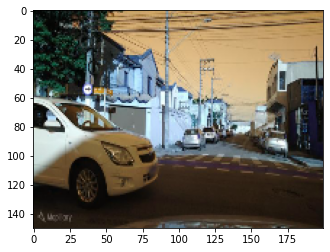

In [15]:
plt.imshow(X_train[3500].reshape(img_height, img_width, 3))

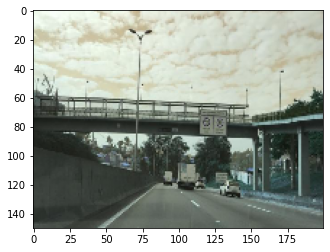

In [16]:
plt.imshow(X_train[300].reshape(img_height, img_width, 3))

In [0]:
from sklearn.preprocessing import LabelEncoder

# set label encoder:
le = LabelEncoder()
le.fit(y_train)

# transform labels:
y_train = le.transform(y_train)
y_val = le.transform(y_val)
# y_test = le.transform(y_test)

y_train = np_utils.to_categorical(y_train.reshape(-1, ), len(set(y_train)))
y_val = np_utils.to_categorical(y_val.reshape(-1, ), len(set(y_val)))

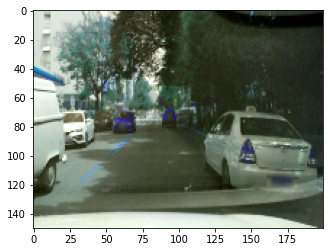

In [18]:
X_train = X_train.reshape((X_train.shape[0], img_height,img_width, 3))
X_val = X_val.reshape((X_val.shape[0], img_height,img_width, 3))
# X_test = X_test.reshape((X_test.shape[0], img_width, img_height, 3))

plt.imshow(X_train[3])

In [0]:
# scale data to the range of [0, 1]:
X_train = X_train.astype("float32") / 255.0
X_val = X_val.astype("float32") / 255.0
# X_test = X_test.astype("float32") / 255.0

In [20]:
# initialize the optimizer and model
print("[INFO] compiling model...")
opt = "adam"
model = LeNet()
model = model.build(numChannels=3, imgRows=150, imgCols=200,
    numClasses=3)
model.compile(loss="categorical_crossentropy", optimizer=opt,
    metrics=["accuracy"])
print("[INFO] compiling DONE")
model.summary()

[INFO] compiling model...
[INFO] compiling DONE
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 150, 200, 100)     2800      
_________________________________________________________________
activation_1 (Activation)    (None, 150, 200, 100)     0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 100, 100)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 100, 50)       125050    
_________________________________________________________________
activation_2 (Activation)    (None, 75, 100, 50)       0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 37, 50, 50)        0         
_________________________________________________________________
flatte

In [21]:
model.fit(X_train, y_train, batch_size=200, epochs=20, verbose=1)

Epoch 1/20
19206/19206 [==============================] - 89s 5ms/step - loss: 0.8449 - accuracy: 0.7436
Epoch 2/20
19206/19206 [==============================] - 78s 4ms/step - loss: 0.2515 - accuracy: 0.9057
Epoch 3/20
19206/19206 [==============================] - 78s 4ms/step - loss: 0.1347 - accuracy: 0.9506
Epoch 4/20
19206/19206 [==============================] - 78s 4ms/step - loss: 0.0690 - accuracy: 0.9749
Epoch 5/20
19206/19206 [==============================] - 78s 4ms/step - loss: 0.0336 - accuracy: 0.9894
Epoch 6/20
19206/19206 [==============================] - 78s 4ms/step - loss: 0.0212 - accuracy: 0.9931
Epoch 7/20
19206/19206 [==============================] - 79s 4ms/step - loss: 0.0090 - accuracy: 0.9979
Epoch 8/20
19206/19206 [==============================] - 79s 4ms/step - loss: 0.0108 - accuracy: 0.9965
Epoch 9/20
19206/19206 [==============================] - 78s 4ms/step - loss: 0.0284 - accuracy: 0.9905
Epoch 10/20
19206/19206 [==============================